In [ ]:
import scipy.io
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from sklearn.metrics import accuracy_score , confusion_matrix , classification_report
from sklearn.preprocessing import StandardScaler , OneHotEncoder
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from sklearn.model_selection import KFold , StratifiedKFold





In [ ]:
print(f'Data selection based on my student ID \
      {40101924%4}')

Data selection based on my student ID       0


## Loading the data

In [ ]:
# Normal dataset
!wget -q https://engineering.case.edu/sites/default/files/97.mat


# Faulty dataset
!wget -q https://engineering.case.edu/sites/default/files/105.mat
!wget -q https://engineering.case.edu/sites/default/files/118.mat
!wget -q https://engineering.case.edu/sites/default/files/130.mat

In [ ]:
# Load .mat file
N_mat  = scipy.io.loadmat('97.mat')
F1_mat = scipy.io.loadmat('105.mat')
F2_mat = scipy.io.loadmat('118.mat')
F3_mat = scipy.io.loadmat('130.mat')

info_N = scipy.io.whosmat('97.mat')
info_F1 = scipy.io.whosmat('105.mat')
info_F2 = scipy.io.whosmat('118.mat')
info_F3 = scipy.io.whosmat('130.mat')

print(info_N)
print(info_F1)
print(info_F2)
print(info_F3)

# Extract the data

Normal_data = N_mat ['X097_DE_time']
Fault_data1 = F1_mat ['X105_DE_time']
Fault_data2 = F2_mat ['X118_DE_time']
Fault_data3 = F3_mat ['X130_DE_time']

Normal_data.shape,Fault_data1.shape,Fault_data2.shape ,Fault_data3.shape
# DataFrame
N_df = pd.DataFrame(Normal_data)
F1_df = pd.DataFrame(Fault_data1)
F2_df = pd.DataFrame(Fault_data2)
F3_df = pd.DataFrame(Fault_data3)
#checking if there is null data
print(N_df.isnull().sum())
print(F1_df.isnull().sum())
print(F2_df.isnull().sum())
print(F3_df.isnull().sum())


[('X097_DE_time', (243938, 1), 'double'), ('X097_FE_time', (243938, 1), 'double'), ('X097RPM', (1, 1), 'double')]
[('X105_DE_time', (121265, 1), 'double'), ('X105_FE_time', (121265, 1), 'double'), ('X105_BA_time', (121265, 1), 'double'), ('X105RPM', (1, 1), 'double')]
[('X118_DE_time', (122571, 1), 'double'), ('X118_FE_time', (122571, 1), 'double'), ('X118_BA_time', (122571, 1), 'double'), ('X118RPM', (1, 1), 'double')]
[('X130_DE_time', (121991, 1), 'double'), ('X130_FE_time', (121991, 1), 'double'), ('X130_BA_time', (121991, 1), 'double'), ('X130RPM', (1, 1), 'double')]
0    0
dtype: int64
0    0
dtype: int64
0    0
dtype: int64
0    0
dtype: int64


## Feature extraction

In [ ]:

# Extracting random M*N matrix
def extr(data, M, N):
    if len(data) < M * N:
        raise ValueError("The dataset does not have enough elements to form an MxN matrix.")

    # Shuffle the array
    np.random.shuffle(data)

    # Extract the first M*N elements and reshape them into an MxN matrix
    matrix = np.array(data[:M * N]).reshape(M, N)
    return matrix

M = 100
N = 200
Normal = extr(Normal_data,M,N)
Fault1 = extr(Fault_data1,M,N)
Fault2 = extr(Fault_data2,M,N)
Fault3 = extr(Fault_data3,M,N)
Normal.shape , Fault1.shape , Fault2.shape , Fault3.shape

((100, 200), (100, 200), (100, 200), (100, 200))

In [ ]:
from scipy import stats

class FeatureExtraction:
    def __init__(self, matrix):
        self.matrix = matrix
        self.features = {
            'standard_deviation': self.standard_deviation(),
            'peak': self.peak(),
            'skewness': self.skewness(),
            'kurtosis' : self.kurtosis(),
            'crest_factor': self.crest_factor(),
            'clearance_factor' : self.clearance_factor(),
            'peak_to_peak' : self.peak_to_peak(),
            'shape_factor' : self.shape_factor(),
            'impact_factor': self.impact_factor(),
            'square_mean_root' : self.square_mean_root(),
            'mean': self.mean(),
            'absolute_mean': self.absolute_mean(),
            'root_mean_square': self.root_mean_square(),
            'impulse_factor' : self.impulse_factor()
        }

    def mean(self):
        return np.mean(self.matrix, axis=1)

    def absolute_mean(self):
        return np.mean(np.abs(self.matrix), axis=1)

    def standard_deviation(self):
        return np.std(self.matrix, axis=1)

    def peak(self):
        return np.max(self.matrix, axis=1)

    def skewness(self):
        return stats.skew(self.matrix, axis=1)

    def kurtosis(self):
        return stats.kurtosis(self.matrix, axis=1)

    def crest_factor(self):
        return self.peak() / self.root_mean_square()

    def clearance_factor(self):
        return self.peak() / np.square(self.square_mean_root())

    def peak_to_peak(self):
        return np.ptp(self.matrix, axis=1)

    def shape_factor(self):
        return self.root_mean_square() / self.absolute_mean()

    def impact_factor(self):
        return np.max(np.abs(self.matrix), axis=1) / self.absolute_mean()

    def square_mean_root(self):
        return np.square(np.mean(np.sqrt(np.abs(self.matrix)), axis=1))

    def root_mean_square(self):
        return np.sqrt(np.mean(np.square(self.matrix), axis=1))

    def impulse_factor(self):
        return np.max(np.abs(self.matrix), axis=1) / np.mean(np.abs(self.matrix), axis=1)




In [ ]:

def process_datasets(normal, fault1, fault2 ,fault3):

    n_fe = FeatureExtraction(normal).features
    f_fe1 = FeatureExtraction(fault1).features
    f_fe2 = FeatureExtraction(fault2).features
    f_fe3 = FeatureExtraction(fault3).features
    # Convert dictionaries to arrays
    normal_ar = np.array(list(n_fe.values())).T
    fault1_ar = np.array(list(f_fe1.values())).T
    fault2_ar = np.array(list(f_fe2.values())).T
    fault3_ar = np.array(list(f_fe3.values())).T
    # Combine the features into a single dataset
    combined_features = np.concatenate((normal_ar,fault1_ar,fault2_ar,fault3_ar), axis=0)

    # create labels, 0 for normal, 1 for fault
    labels = np.concatenate((np.zeros(normal_ar.shape[0]), np.ones(fault1_ar.shape[0]),
                              np.full(fault2_ar.shape[0],2), np.full(fault3_ar.shape[0],3)))

    return combined_features, labels

# X is combined_features
# y is Lables
X, y = process_datasets(Normal, Fault1,Fault2,Fault3)
print("Combined Features Shape:", X.shape)
print("Labels:", y.shape)


Combined Features Shape: (400, 14)
Labels: (400,)


In [ ]:
print(y)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.

## Preprocessing

In [ ]:
X_train, X_test_valid, y_train, y_test_valid =train_test_split(X,y,random_state=24,test_size=0.4 , shuffle=True)
X_train.shape, X_test_valid.shape, y_train.shape, y_test_valid.shape



((240, 14), (160, 14), (240,), (160,))

In [ ]:
scaler = StandardScaler()
scaler.fit_transform(X_train)
scaler.transform(X_test_valid)
X_test , X_valid = X_test_valid[:80,:] , X_test_valid[80:,:]
y_test , y_valid = y_test_valid[:80] , y_test_valid[80:]
X_test.shape , X_valid.shape , y_test.shape , y_valid.shape

((80, 14), (80, 14), (80,), (80,))

## keras

### tanh

In [ ]:
# Define the MLP model
model = Sequential()
model.add(Dense(20, activation='tanh',input_shape=(X_train.shape[1],)))
model.add(Dense(20, activation='tanh'))
model.add(Dense(4,activation='softmax'))
#Summary of the model
model.summary()




Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_68 (Dense)            (None, 20)                300       
                                                                 
 dense_69 (Dense)            (None, 20)                420       
                                                                 
 dense_70 (Dense)            (None, 4)                 84        
                                                                 
Total params: 804 (3.14 KB)
Trainable params: 804 (3.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.fit?

In [ ]:

#optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy' , metrics="accuracy")
history = model.fit(X_train, y_train, epochs=50, batch_size=10,
                    steps_per_epoch=10,
                    validation_data=(X_valid, y_valid),
                    )


Epoch 1/50
10/10 [==============================] - 1s 27ms/step - loss: 1.4493 - accuracy: 0.2900 - val_loss: 1.3899 - val_accuracy: 0.5375
Epoch 2/50
10/10 [==============================] - 0s 6ms/step - loss: 1.4085 - accuracy: 0.4600 - val_loss: 1.3652 - val_accuracy: 0.3125
Epoch 3/50
10/10 [==============================] - 0s 6ms/step - loss: 1.3617 - accuracy: 0.3900 - val_loss: 1.3506 - val_accuracy: 0.4250
Epoch 4/50
10/10 [==============================] - 0s 7ms/step - loss: 1.3418 - accuracy: 0.3700 - val_loss: 1.3173 - val_accuracy: 0.4500
Epoch 5/50
10/10 [==============================] - 0s 8ms/step - loss: 1.2974 - accuracy: 0.5000 - val_loss: 1.2620 - val_accuracy: 0.6875
Epoch 6/50
10/10 [==============================] - 0s 7ms/step - loss: 1.1905 - accuracy: 0.7300 - val_loss: 1.1642 - val_accuracy: 0.7125
Epoch 7/50
10/10 [==============================] - 0s 8ms/step - loss: 1.1382 - accuracy: 0.5900 - val_loss: 1.0546 - val_accuracy: 0.5625
Epoch 8/50
10/10 [=

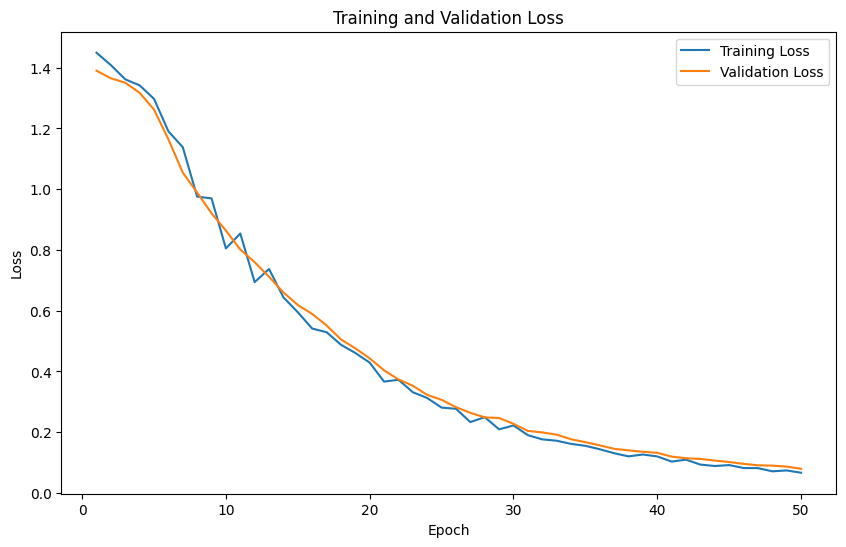

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# Extract loss values
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']

# Create a plot
plt.figure(figsize=(10, 6))

# Plot training loss
sns.lineplot(x=range(1, len(loss_values) + 1), y=loss_values, label='Training Loss')

# Plot validation loss
sns.lineplot(x=range(1, len(val_loss_values) + 1), y=val_loss_values, label='Validation Loss')

# Add titles and labels
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()


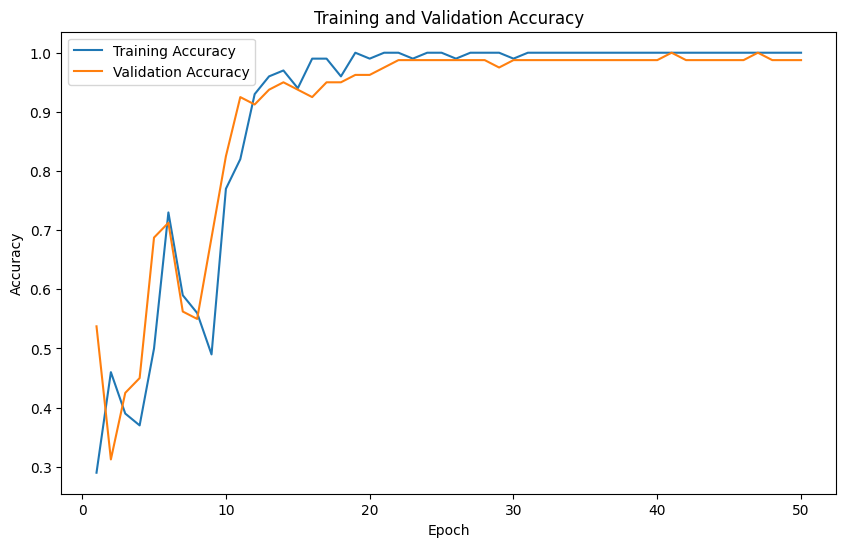

In [ ]:

# Extract accuracy values
accuracy_values = history.history['accuracy']
val_accuracy_values = history.history['val_accuracy']

# Create a plot
plt.figure(figsize=(10, 6))

# Plot training accuracy
plt.plot(range(1, len(accuracy_values) + 1), accuracy_values, label='Training Accuracy')

# Plot validation accuracy
plt.plot(range(1, len(val_accuracy_values) + 1), val_accuracy_values, label='Validation Accuracy')

# Add titles and labels
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.show()


In [ ]:
loss = model.evaluate(X_test , y_test)

3/3 [==============================] - 0s 6ms/step - loss: 0.1102 - accuracy: 1.0000


In [ ]:
y_test.shape, y_pred.shape

((80,), (80,))

In [ ]:

# Make predictions on the test set
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob , axis=1)
# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Display confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))



3/3 [==============================] - 0s 5ms/step
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        21
         1.0       1.00      1.00      1.00        23
         2.0       1.00      1.00      1.00        16
         3.0       1.00      1.00      1.00        20

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80

Confusion Matrix:
[[21  0  0  0]
 [ 0 23  0  0]
 [ 0  0 16  0]
 [ 0  0  0 20]]


### 1 layer relu

Model: "MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 10)                150       
                                                                 
 dense_28 (Dense)            (None, 4)                 44        
                                                                 
Total params: 194 (776.00 Byte)
Trainable params: 194 (776.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
24/24 [==============================] - 1s 26ms/step - loss: 1.4704 - accuracy: 0.1625 - val_loss: 1.2562 - val_accuracy: 0.4750
Epoch 2/50
24/24 [==============================] - 0s 5ms/step - loss: 1.2194 - accuracy: 0.5083 - val_loss: 1.0614 - val_accuracy: 0.7250
Epoch 3/50
24/24 [==============================] - 0s 7ms/step - loss: 1.0237 - accuracy: 0.6375 - val_loss: 0.9214 - val_accuracy: 0.7500


Text(70.72222222222221, 0.5, 'True labels')

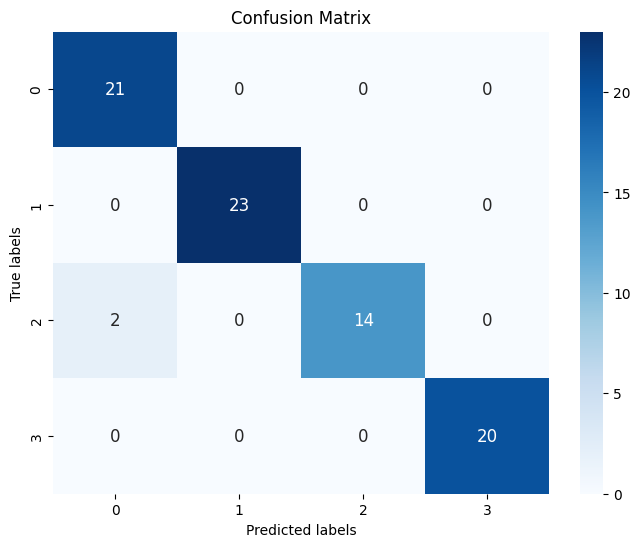

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# Split the dataset
X_train, X_test_valid, y_train, y_test_valid = train_test_split(X, y, random_state=24, test_size=0.4, shuffle=True)
X_test, X_valid = X_test_valid[:80, :], X_test_valid[80:, :]
y_test, y_valid = y_test_valid[:80], y_test_valid[80:]

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_valid = scaler.transform(X_valid)

# Define the MLP model
model = Sequential(name="MLP")
model.add(Dense(10, activation='relu', input_shape=(X_train.shape[1],)))

model.add(Dense(4, activation='softmax'))
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=["accuracy"])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=10, validation_data=(X_valid, y_valid))

# Make predictions on the test set
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))
CM =confusion_matrix(y_test, y_pred)
# Display confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

plt.figure(figsize=(8, 6))
sns.heatmap(CM, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 12})
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')



In [ ]:
y_pred.shape

(80,)

### 2 layer relu One-Hot

Model: "MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_128 (Dense)           (None, 20)                300       
                                                                 
 dense_129 (Dense)           (None, 20)                420       
                                                                 
 dense_130 (Dense)           (None, 4)                 84        
                                                                 
Total params: 804 (3.14 KB)
Trainable params: 804 (3.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
24/24 [==============================] - 3s 36ms/step - loss: 1.1666 - accuracy: 0.4458 - val_loss: 1.0522 - val_accuracy: 0.6875
Epoch 2/50
24/24 [==============================] - 0s 17ms/step - loss: 0.8832 - accuracy: 0.6958 - val_loss: 0.8439 - val_accuracy: 0.7625
Epoch 3/50
24/2

Text(70.72222222222221, 0.5, 'True labels')

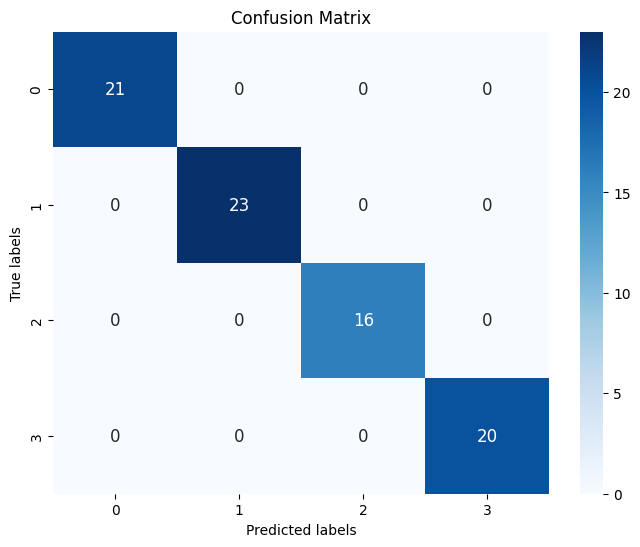

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming X and y are already defined and preprocessed

# Split the dataset
X_train, X_test_valid, y_train, y_test_valid = train_test_split(X, y, random_state=24, test_size=0.4, shuffle=True)
X_test, X_valid = X_test_valid[:80, :], X_test_valid[80:, :]
y_test, y_valid = y_test_valid[:80], y_test_valid[80:]

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_valid = scaler.transform(X_valid)

num_classes = 4

# Convert labels to categorical one-hot encoding
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
y_valid = to_categorical(y_valid, num_classes)

# Define the MLP model
model = Sequential(name="MLP")
model.add(Dense(20, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(20, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Summary of the model
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=10, validation_data=(X_valid, y_valid))

# Evaluate the model
y_pred = np.argmax(model.predict(X_test), axis=1)
y_test_int = np.argmax(y_test, axis=1)

from sklearn.metrics import classification_report, confusion_matrix

# Display classification report
print("Classification Report:")
print(classification_report(y_test_int, y_pred))

# Display confusion matrix
CM2 = confusion_matrix(y_test_int, y_pred)
print("Confusion Matrix:")
print(confusion_matrix(y_test_int, y_pred))

plt.figure(figsize=(8, 6))
sns.heatmap(CM2, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 12})
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')



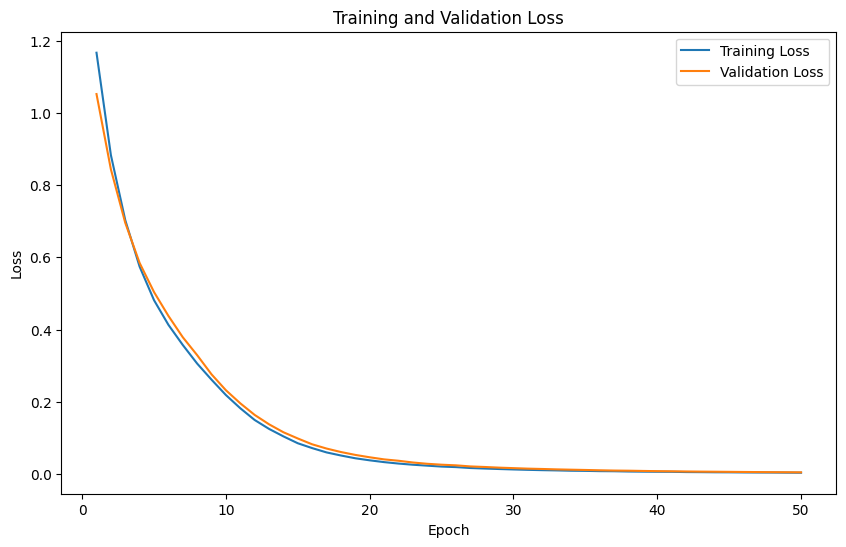

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# Extract loss values
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']

# Create a plot
plt.figure(figsize=(10, 6))

# Plot training loss
sns.lineplot(x=range(1, len(loss_values) + 1), y=loss_values, label='Training Loss')

# Plot validation loss
sns.lineplot(x=range(1, len(val_loss_values) + 1), y=val_loss_values, label='Validation Loss')

# Add titles and labels
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()

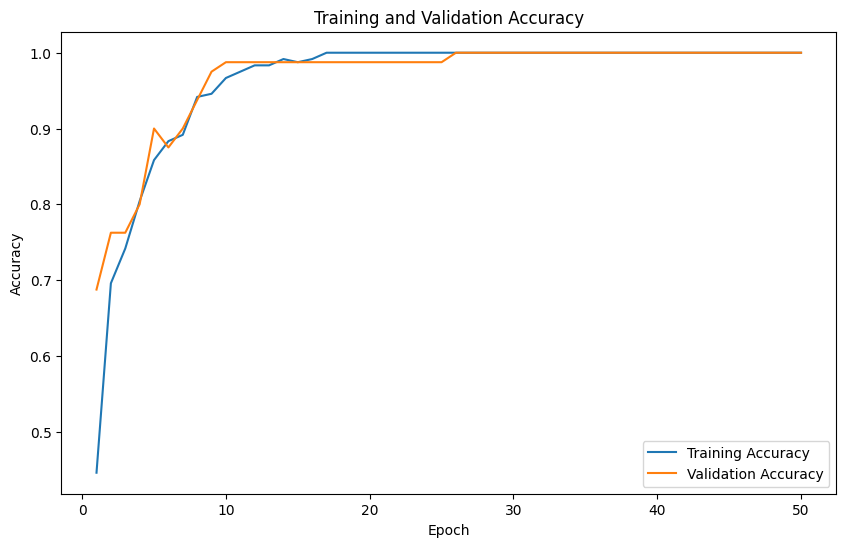

In [ ]:
# Extract accuracy values
accuracy_values = history.history['accuracy']
val_accuracy_values = history.history['val_accuracy']

# Create a plot
plt.figure(figsize=(10, 6))

# Plot training accuracy
plt.plot(range(1, len(accuracy_values) + 1), accuracy_values, label='Training Accuracy')

# Plot validation accuracy
plt.plot(range(1, len(val_accuracy_values) + 1), val_accuracy_values, label='Validation Accuracy')

# Add titles and labels
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.show()


### 2 Layer ReLU Int

Model: "MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_131 (Dense)           (None, 20)                300       
                                                                 
 dense_132 (Dense)           (None, 20)                420       
                                                                 
 dense_133 (Dense)           (None, 4)                 84        
                                                                 
Total params: 804 (3.14 KB)
Trainable params: 804 (3.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
24/24 [==============================] - 1s 11ms/step - loss: 1.2141 - accuracy: 0.4917 - val_loss: 1.2021 - val_accuracy: 0.5875
Epoch 2/50
24/24 [==============================] - 0s 4ms/step - loss: 1.0957 - accuracy: 0.6250 - val_loss: 1.1148 - val_accuracy: 0.5750
Epoch 3/50
24/24

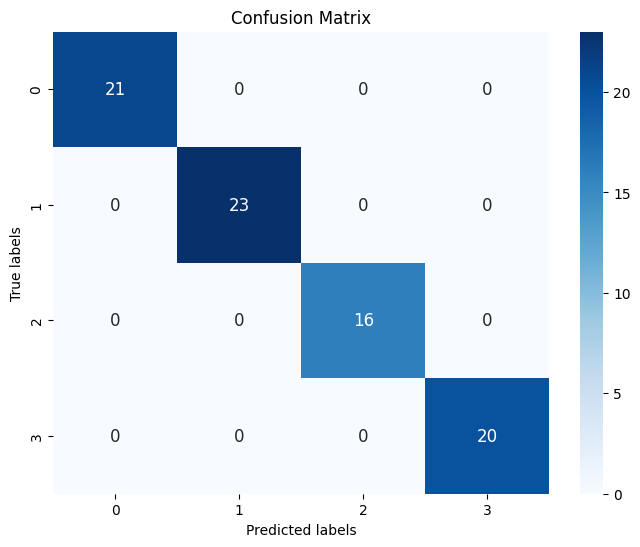

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming X and y are already defined and preprocessed

# Split the dataset
X_train, X_test_valid, y_train, y_test_valid = train_test_split(X, y, random_state=24, test_size=0.4, shuffle=True)
X_test, X_valid = X_test_valid[:80, :], X_test_valid[80:, :]
y_test, y_valid = y_test_valid[:80], y_test_valid[80:]

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_valid = scaler.transform(X_valid)

# Define the MLP model
model = Sequential(name="MLP")
model.add(Dense(20, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(20, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Summary of the model
model.summary()

# Compile the model
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=10, validation_data=(X_valid, y_valid))

# Evaluate the model
y_pred = np.argmax(model.predict(X_test), axis=1)

# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Display confusion matrix
CM2 = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

plt.figure(figsize=(8, 6))
sns.heatmap(CM2, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 12})
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


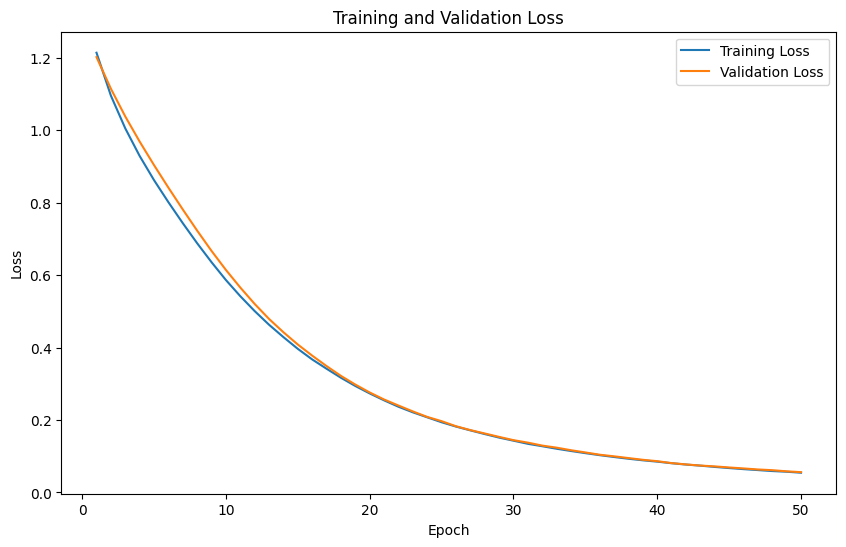

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# Extract loss values
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']

# Create a plot
plt.figure(figsize=(10, 6))

# Plot training loss
sns.lineplot(x=range(1, len(loss_values) + 1), y=loss_values, label='Training Loss')

# Plot validation loss
sns.lineplot(x=range(1, len(val_loss_values) + 1), y=val_loss_values, label='Validation Loss')

# Add titles and labels
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()

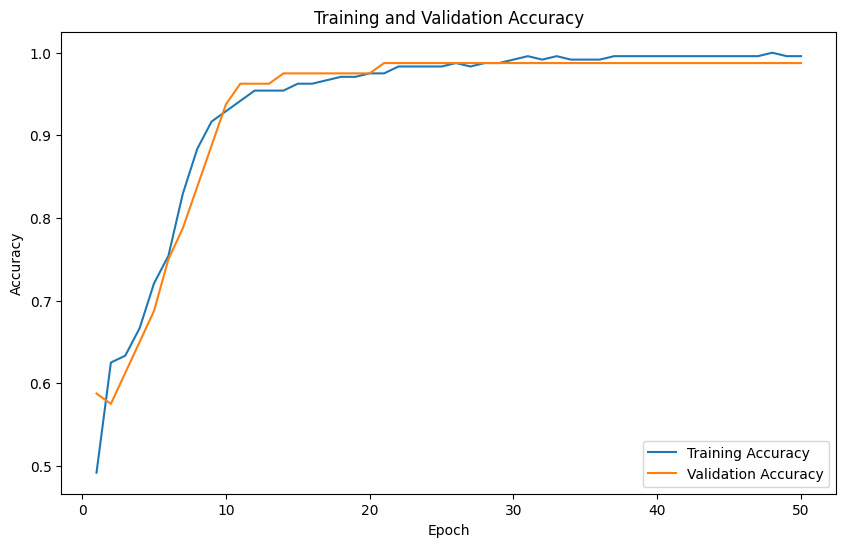

In [ ]:
# Extract accuracy values
accuracy_values = history.history['accuracy']
val_accuracy_values = history.history['val_accuracy']

# Create a plot
plt.figure(figsize=(10, 6))

# Plot training accuracy
plt.plot(range(1, len(accuracy_values) + 1), accuracy_values, label='Training Accuracy')

# Plot validation accuracy
plt.plot(range(1, len(val_accuracy_values) + 1), val_accuracy_values, label='Validation Accuracy')

# Add titles and labels
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.show()

### neurons

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def create_and_train_model(X_train, y_train, X_valid, y_valid, neurons):
    num_classes = 4

    # Convert labels to categorical one-hot encoding
    y_train = to_categorical(y_train, num_classes)
    y_valid = to_categorical(y_valid, num_classes)

    # Define the MLP model
    model = Sequential(name="MLP")
    model.add(Dense(neurons, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dense(neurons, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=50, batch_size=10, validation_data=(X_valid, y_valid), verbose=0)

    return history


In [ ]:
# Assuming X and y are already defined and preprocessed

# Split the dataset
X_train, X_test_valid, y_train, y_test_valid = train_test_split(X, y, random_state=24, test_size=0.4, shuffle=True)
X_test, X_valid = X_test_valid[:80, :], X_test_valid[80:, :]
y_test, y_valid = y_test_valid[:80], y_test_valid[80:]

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_valid = scaler.transform(X_valid)

neuron_counts = [1, 5, 10, 15, 20]
train_losses = []
val_losses = []

for neurons in neuron_counts:
    history = create_and_train_model(X_train, y_train, X_valid, y_valid, neurons)
    train_losses.append(history.history['loss'][-1])
    val_losses.append(history.history['val_loss'][-1])


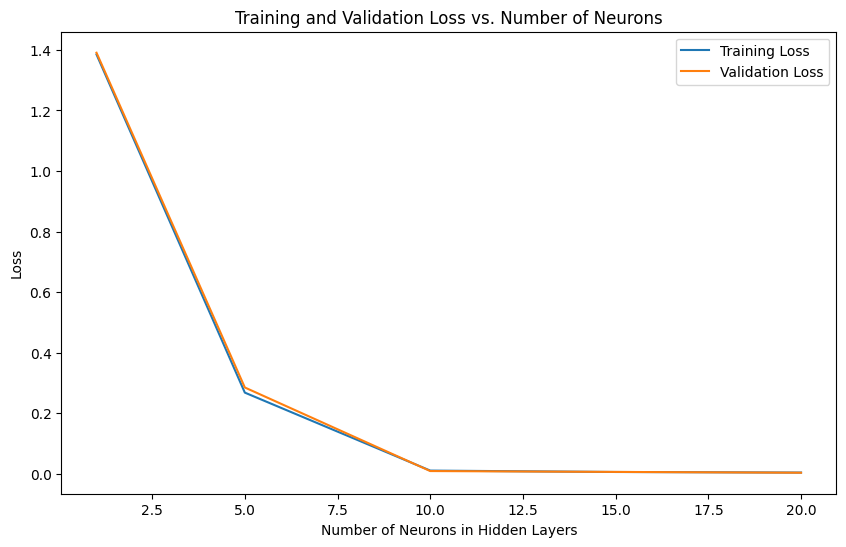

In [ ]:
# Plot the training and validation loss against the number of neurons
plt.figure(figsize=(10, 6))
plt.plot(neuron_counts, train_losses, label='Training Loss')
plt.plot(neuron_counts, val_losses, label='Validation Loss')
plt.xlabel('Number of Neurons in Hidden Layers')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs. Number of Neurons')
plt.legend()
plt.show()


## KFold

In [ ]:
# Set random seed for reproducibility
#np.random.seed(24)
#tf.random.set_seed(24)

# Initialize K-Fold
k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=24)

# Lists to store the results
fold_accuracies = []

# Perform K-Fold Cross-Validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Scale the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Define the MLP model
    model = Sequential(name="MLP")
    model.add(Dense(10, activation='sigmoid', input_shape=(X_train.shape[1],)))
    model.add(Dense(4, activation='softmax'))  # Output layer with 4 neurons for 4 classes

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=50, batch_size=10, validation_split=0.1, verbose=0)

    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    fold_accuracies.append(test_accuracy)

    print(f'Fold Test Accuracy: {test_accuracy}')

# Calculate the average accuracy
average_accuracy = np.mean(fold_accuracies)
print(f'Average Accuracy over {k} folds: {average_accuracy}')


Fold Test Accuracy: 1.0
Fold Test Accuracy: 0.987500011920929
Fold Test Accuracy: 1.0
Fold Test Accuracy: 1.0
Fold Test Accuracy: 1.0
Average Accuracy over 5 folds: 0.9975000023841858


## scikit learn

In [ ]:
from sklearn.neural_network import MLPClassifier, MLPRegressor



In [ ]:
model = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam',
                      alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001,
                      power_t=0.5, max_iter=50, shuffle=True, random_state=24, tol=0.0001, verbose=True,
                      warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.15,
                      beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, max_fun=15000)

In [ ]:
#MLPClassifier?


Init signature:
MLPClassifier(
    hidden_layer_sizes=(100,),
    activation='relu',
    *,
    solver='adam',
    alpha=0.0001,
    batch_size='auto',
    learning_rate='constant',
    learning_rate_init=0.001,
    power_t=0.5,
    max_iter=200,
    shuffle=True,
    random_state=None,
    tol=0.0001,
    verbose=False,
    warm_start=False,
    momentum=0.9,
    nesterovs_momentum=True,
    early_stopping=False,
    validation_fraction=0.1,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-08,
    n_iter_no_change=10,
    max_fun=15000,
)
Docstring:     
Multi-layer Perceptron classifier.

This model optimizes the log-loss function using LBFGS or stochastic
gradient descent.

.. versionadded:: 0.18

Parameters
----------
hidden_layer_sizes : array-like of shape(n_layers - 2,), default=(100,)
    The ith element represents the number of neurons in the ith
    hidden layer.

activation : {'identity', 'logistic', 'tanh', 'relu'}, default='relu'
    Activation function for the hidden laye

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Assuming X and y are already defined and preprocessed

# Split the dataset
X_train, X_test_valid, y_train, y_test_valid = train_test_split(X, y, random_state=24, test_size=0.4, shuffle=True)
X_test, X_valid = X_test_valid[:80, :], X_test_valid[80:, :]
y_test, y_valid = y_test_valid[:80], y_test_valid[80:]

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_valid = scaler.transform(X_valid)

# Define the MLP model
model = MLPClassifier(hidden_layer_sizes=(10, 5, 4), activation='tanh', solver='adam',
                      random_state=24, max_iter=50, verbose=True)

# Train the model
history = model.fit(X_train, y_train)

# Evaluate the model
test_score = model.score(X_test, y_test)
valid_score = model.score(X_valid, y_valid)
print("Test Score:", test_score)
print("Validation Score:", valid_score)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Display confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Iteration 1, loss = 1.83036488
Iteration 2, loss = 1.80441750
Iteration 3, loss = 1.77899362
Iteration 4, loss = 1.75422930
Iteration 5, loss = 1.73106769
Iteration 6, loss = 1.70708947
Iteration 7, loss = 1.68324065
Iteration 8, loss = 1.66202208
Iteration 9, loss = 1.64038525
Iteration 10, loss = 1.61940593
Iteration 11, loss = 1.59979801
Iteration 12, loss = 1.58103401
Iteration 13, loss = 1.56309868
Iteration 14, loss = 1.54519887
Iteration 15, loss = 1.52883997
Iteration 16, loss = 1.51305614
Iteration 17, loss = 1.49745771
Iteration 18, loss = 1.48243570
Iteration 19, loss = 1.46802419
Iteration 20, loss = 1.45335230
Iteration 21, loss = 1.43909022
Iteration 22, loss = 1.42504030
Iteration 23, loss = 1.41112144
Iteration 24, loss = 1.39778367
Iteration 25, loss = 1.38474343
Iteration 26, loss = 1.37173670
Iteration 27, loss = 1.35930417
Iteration 28, loss = 1.34643197
Iteration 29, loss = 1.33470723
Iteration 30, loss = 1.32292721
Iteration 31, loss = 1.31128823
Iteration 32, los

/home/amir/miniconda3/envs/PY/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/amir/miniconda3/envs/PY/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/amir/miniconda3/envs/PY/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/amir/miniconda3/envs/PY/lib/python3.11/site-packages/sklearn/metrics/_class

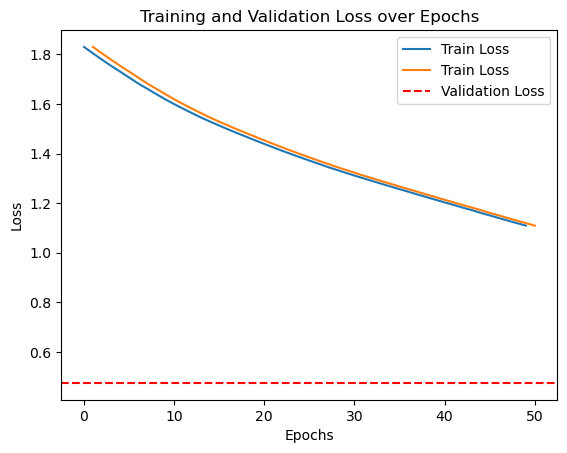

In [ ]:
# Plot the training loss
plt.plot(history.loss_curve_, label='Train Loss')

# Extract loss values from the printed output
train_loss = np.array(model.loss_curve_)

# Get the validation loss by evaluating the model on the validation set
val_loss = model.score(X_valid, y_valid)

# Plot the training and validation loss
plt.plot(np.arange(1, len(train_loss) + 1), train_loss, label='Train Loss')
plt.axhline(y=val_loss, color='r', linestyle='--', label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()